In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
cuda_enabled = torch.cuda.is_available()
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#cuda_enabled = False
CUDA_VISIBLE_DEVICES=0,1,2,3
cudnn.benchmark = True

from skimage import io, transform
import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np
import glob
from __future__ import print_function, division
import datetime
import sys
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split



# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


#### Bidirectional Recurrent Neural Network

In [2]:
# Bidirectional recurrent neural network (many-to-one)
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.is_training = False
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Dropout(p=0.5, inplace=False)
        # (-1, sequence_length * input_size)
        # self.linear = nn.Linear(3*244*244, num_classes)
        # self.linear = nn.Linear(144, 256)
        self.linear = nn.Linear(self.hidden_size*2, self.num_classes)
        # self.linear = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        # print(h0)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        # print(c0)
        # if cuda_enabled:
        #     h0 = h0.cuda()  # 2 for bidirection
        #     c0 = c0.cuda()
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode hidden state of last time step
        if self.is_training:
            out = self.fc(out[:, -1, :])
        else:
            out = out[:, -1, :]
        # out = F.log_softmax(self.linear(out), dim=1)
        return out



#### Body and Eye Tracking Dataset

Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample.

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

Sample of our dataset will be a dict
``{'image': image, 'landmarks': landmarks}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the
next section.




In [3]:
class BodyandEyeLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):#root_dir = img_dir
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)#same as image label

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name) #same as: image = read_image(img_path)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        # landmarks = self.landmarks_frame.iloc[idx, 1]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        return sample

#         if self.transform:
#             image = self.transform(image)

#         return image, landmarks

Transforms
----------

One issue we can see from the above is that the samples are not of the
same size. Most neural networks expect the images of a fixed size.
Therefore, we will need to write some preprocessing code.
Let's create three transforms:

-  ``Rescale``: to scale the image
-  ``RandomCrop``: to crop from image randomly. This is data
   augmentation.
-  ``ToTensor``: to convert the numpy images to torch images (we need to
   swap axes).

We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and
if required, ``__init__`` method. We can then use a transform like this:

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)

Observe below how these transforms had to be applied both on the image and
landmarks.




In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float(),
                'landmarks': torch.from_numpy(landmarks).float()}

In [5]:
dataset = BodyandEyeLandmarksDataset(csv_file='../data/faces/face_landmarks.csv',
                                                      root_dir='../data/faces/',
                                                      transform=transforms.Compose([
                                                           Rescale(256), RandomCrop(224),ToTensor()])
                                                     )

In [6]:
#NN Data
print('Starting NN dataset -------------------------------------')
def train_total_dataset(dataset, total_split=0.30): #Training set be 70% of the dataset
    train_idx, total_idx = train_test_split(list(range(len(dataset))), test_size=total_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['total_split'] = Subset(dataset, total_idx)
    return datasets
def test_val_dataset(dataset, total_split=0.5): #Testing and Validation set be 15% (50% of the remaining 30% of the dataset) 
    test_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=total_split)
    datasets = {}
    datasets['test'] = Subset(dataset, test_idx)
    datasets['validation'] = Subset(dataset, val_idx)
    return datasets

datasets = train_total_dataset(dataset)
train = datasets['train']
datasets_split = test_val_dataset(datasets['total_split'])
test = datasets_split['test']
validation = datasets_split['validation']

# The original dataset is available in the Subset class
print(len(datasets['train'].dataset), datasets['train'].dataset)
print(len(train), train)
print(len(test), test)
print(len(validation), validation)


timing = dict() 
timing['start'] = datetime.datetime.now()

# hyperparams for the network
batch_size = 64
kwargs = {'num_workers': 1, 'pin_memory': True}
# if not cuda_enabled:
#     kwargs['pin_memory'] = False
#     batch_size = 32

print('Starting NN loader -------------------------------------')
timing['training'] = datetime.datetime.now()
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True,num_workers=0)
# train_loader = DataLoader(dataset=train, batch_size=4, shuffle=True,num_workers=0)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False, num_workers=0)
# test_loader = DataLoader(dataset=test, batch_size=4, shuffle=True,num_workers=0)
validation_loader = DataLoader(dataset=validation, batch_size=batch_size, shuffle=False, num_workers=0)
# validation_loader = DataLoader(dataset=validation, batch_size=4, shuffle=True,num_workers=0)
# train_loader = DataLoader(train, batch_size=64, shuffle=True)
# test_loader = DataLoader(test, batch_size=64, shuffle=True)
print(len(train_loader), train_loader)
print(len(test_loader), test_loader)
# print(len(validation_loader), validation_loader)
print('Finish   -------------------------------------')



Starting NN dataset -------------------------------------
69 <__main__.BodyandEyeLandmarksDataset object at 0x7f8235e38130>
48 <torch.utils.data.dataset.Subset object at 0x7f8235df46d0>
10 <torch.utils.data.dataset.Subset object at 0x7f823d00c7c0>
11 <torch.utils.data.dataset.Subset object at 0x7f823d00c100>
Starting NN loader -------------------------------------
1 <torch.utils.data.dataloader.DataLoader object at 0x7f823d03e850>
1 <torch.utils.data.dataloader.DataLoader object at 0x7f823d03e880>
Finish   -------------------------------------


Images batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32, 68, 2])
torch.Size([32, 3, 224, 224])


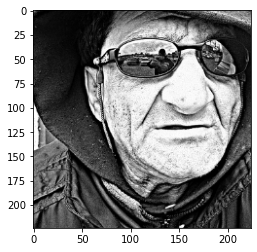

Label: tensor([[ 74.5547,  79.0360],
        [ 77.9680,  97.4500],
        [ 82.7467, 116.5460],
        [ 89.5733, 134.2780],
        [100.4960, 151.3280],
        [115.5147, 164.9680],
        [133.2640, 174.5160],
        [151.6960, 179.2900],
        [169.4453, 176.5620],
        [182.4160, 169.7420],
        [193.3387, 156.1020],
        [200.8480, 141.7800],
        [207.6747, 126.0940],
        [212.4533, 110.4080],
        [213.1360,  95.4040],
        [210.4053,  81.7640],
        [207.6747,  68.1240],
        [ 96.4000,  64.7140],
        [104.5920,  54.4840],
        [118.2453,  47.6640],
        [132.5813,  45.6180],
        [145.5520,  49.7100],
        [163.3013,  44.2540],
        [172.1760,  38.7980],
        [182.4160,  38.1160],
        [191.2907,  42.8900],
        [195.3867,  51.0740],
        [156.4747,  58.5760],
        [159.8880,  70.8520],
        [162.6187,  82.4460],
        [166.0320,  94.7220],
        [143.5040, 103.5880],
        [152.3787, 106.3160],
   

In [192]:
# Display image and label.
sample = next(iter(train_loader))
images, labels = sample['image'], sample['landmarks']
# train_labels
print(f"Images batch shape: {images.size()}")
# print(images[0].shape)
print(f"Labels batch shape: {labels.size()}")
img = images[0].squeeze()
# print(images)
print(images.squeeze().shape)
label = labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {label}")

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


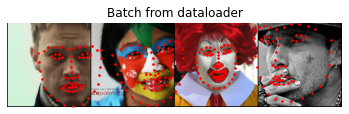

In [105]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

#### Body and Eye Tracking LSTM

In [220]:
#Init NN
input_size = 224
sequence_length = 224
hidden_size = 128
num_layers = 2
num_classes = 3  # TODO: Determine this from the data
learning_rate = 0.0001
num_epochs = 300

# The network
model = BiRNN(input_size, hidden_size, num_layers, num_classes).to(device)
model.is_training = True

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_loss = 5000000000.

In [225]:
# Train the model
# total_step = len(train_loader)
for epoch in range(num_epochs):
    loss_total = 0.
    iteration_count = 0.
    for i, sample in enumerate(train_loader):
        iteration_count += 1.
        images, labels = sample['image'], sample['landmarks']        
        images = Variable(images.view(-1, sequence_length, input_size))
        labels = Variable(labels)
        if cuda_enabled:
            images = images.cuda()
            labels = labels.cuda()

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_total += loss.data[0]
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   % (epoch + 1, num_epochs, i + 1, len(train) // batch_size, loss.data[0]))
                   # .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    current_epoch_loss = loss_total / iteration_count
    print('Epoch %d; loss = %0.4f' % (epoch, current_epoch_loss))

    epoch_loss = current_epoch_loss

timing['training'] = datetime.datetime.now() - timing['training']

ValueError: Expected input batch_size (144) to match target batch_size (48).

In [81]:
# # Test the Model
model.is_training = False
timing['testing'] = datetime.datetime.now()
print('Testing -----------------------------------------------')
correct = 0.0
total = 0.0
predicted_list = []
label_list = []
for mfcc, labels in test_loader:#test_loader
    mfcc = Variable(mfcc.view(-1, sequence_length, input_size))
    if cuda_enabled:
        mfcc = mfcc.cuda()

    outputs = rnn(mfcc)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    for p, l in zip(predicted, labels):
        predicted_list.append(p)
        label_list.append(l)
        if p == l:
            correct += 1.0

timing['testing'] = datetime.datetime.now() - timing['testing']

In [52]:
# Save the Model
torch.save(model.state_dict(), 'ShouldIDrive_body_tracking.pkl')

In [53]:
# Analyze NN
print('Timing (feature extraction, training, timing)')
print('=============================================')
print(timing['features'])
print(timing['training'])
print(timing['testing'])
print('')
print('=============================================')
print('')
print('Confusion Matrix')
print('================')
# print(train.get_encoder().classes_)
print(confusion_matrix(label_list, predicted_list))
print('=============================================')
print('Accuracy = %0.4f' % (accuracy_score(label_list, predicted_list)))
print('=============================================')

In [7]:
# # # Train NN
# for epoch in range(num_epochs):
#     loss_total = 0.
#     iteration_count = 0.
#     for i, (mfcc, labels) in enumerate(train_loader):
#         iteration_count += 1.
#         mfcc = Variable(mfcc.view(-1, sequence_length, input_size))
#         labels = Variable(labels)
#         if cuda_enabled:
#             mfcc = mfcc.cuda()
#             labels = labels.cuda()

#         # Forward + Backward + Optimize
#         optimizer.zero_grad()
#         outputs = model(mfcc)

#         loss = criterion(outputs, labels)
#         loss_total += loss.data[0]
#         loss.backward()
#         optimizer.step()

#         if (i + 1) % 10 == 0:
#             print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
#                   % (epoch + 1, num_epochs, i + 1, len(train) // batch_size, loss.data[0]))
#     current_epoch_loss = loss_total / iteration_count
#     print('Epoch %d; loss = %0.4f' % (epoch, current_epoch_loss))

#     epoch_loss = current_epoch_loss

#     timing['training'] = datetime.datetime.now() - timing['training']

In [7]:
# Test the model
# with torch.no_grad():
#     model.is_training = False
#     correct = 0
#     total = 0
#     for images, labels in test_loader:
#         images = images.reshape(-1, sequence_length, input_size).to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

Test Accuracy of the model on the 10000 test images: 97.39 %
